In [1]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)
 
%load_ext autoreload
%autoreload 2

In [18]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd

sns.set_theme(style="white")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

CAMBIOS_GLOSAS = {
    "Región Del Bíobío": "Región del Bío-Bío",
    "Región Metropolitana de Santiago": "Región Metropolitana de Santiago",
    "Región del Libertador General Bernardo O'Higgins": "Región del Libertador Bernardo O'Higgins",
    "Región De Antofagasta": "Región de Antofagasta",
    "Región De Los Lagos": "Región de Los Lagos",
    "Región Del Maule": "Región del Maule",
    "Región De Valparaíso": "Región de Valparaíso",
    "Región De Arica y Parinacota": "Región de Arica y Parinacota",
    "Región De Tarapacá": "Región de Tarapacá",
    "Región Aysén del General Carlos Ibáñez del Campo": "Región de Aysén del Gral.Ibañez del Campo",
    "Región De Coquimbo": "Región de Coquimbo",
    "Región De Magallanes y de La Antártica Chilena": "Región de Magallanes y Antártica Chilena",
    "Región De La Araucanía": "Región de La Araucanía",
    "Región De Atacama": "Región de Atacama",
    "Región De Ñuble": "Región de Ñuble",
    "Región De Los Ríos": "Región de Los Ríos",
}

In [19]:
df = pd.read_csv("../data/processed/df_procesada.csv")

In [23]:
# Eliminamos las filas que no tienen fecha de evaluación
df_limpia = df.dropna(subset="fecha_1_evaluacion").copy()
df_limpia = df_limpia.query("anio_1_evaluacion >= 2000")

df_limpia["region"] = df_limpia["region"].str.replace(", Chile", "")
df_limpia["region"] = df_limpia["region"].replace(CAMBIOS_GLOSAS)

df_limpia["fecha_1_evaluacion"] = pd.to_datetime(df_limpia["fecha_1_evaluacion"])
df_limpia["f_nac"] = pd.to_datetime(df_limpia["f_nac"])
df_limpia["edad_1_evaluacion_calc"] = (
    df_limpia["fecha_1_evaluacion"] - df_limpia["f_nac"]
).dt.days / 365

In [28]:
# Obtiene la cantidad de pacientes anuales
cantidad_de_pacientes = df_limpia.groupby("anio_1_evaluacion")["rut"].nunique()

# Obtiene la distribucion de la prevision a lo largo de los anios
prevision = df_limpia.groupby("anio_1_evaluacion")["prevision"].value_counts().unstack()
prevision.loc["Total", :] =  prevision.sum()

# Obtiene la distribucion de la 1era edad de consulta
edad_primera_consulta = df_limpia.groupby("anio_1_evaluacion")["edad_1_evaluacion_calc"].describe()

# Obtiene el desglose por region
desglose_por_region = df_limpia.groupby("region")["rut"].nunique()

In [7]:
map_df = gpd.read_file("../data/raw/mapas/Regional.shp")

In [88]:
resumen_regiones = map_df.set_index("Region").join(desglose_por_region)

# Define the bounding box for Chile (adjust the coordinates as needed)
minx, miny, maxx, maxy = -9000000, -7554435.5874,  -7393641.8015, -1978919.7457

# Filter the GeoDataFrame to include only the polygons within the bounding box
resumen_regiones_filtrado = resumen_regiones.cx[minx:maxx, miny:maxy]

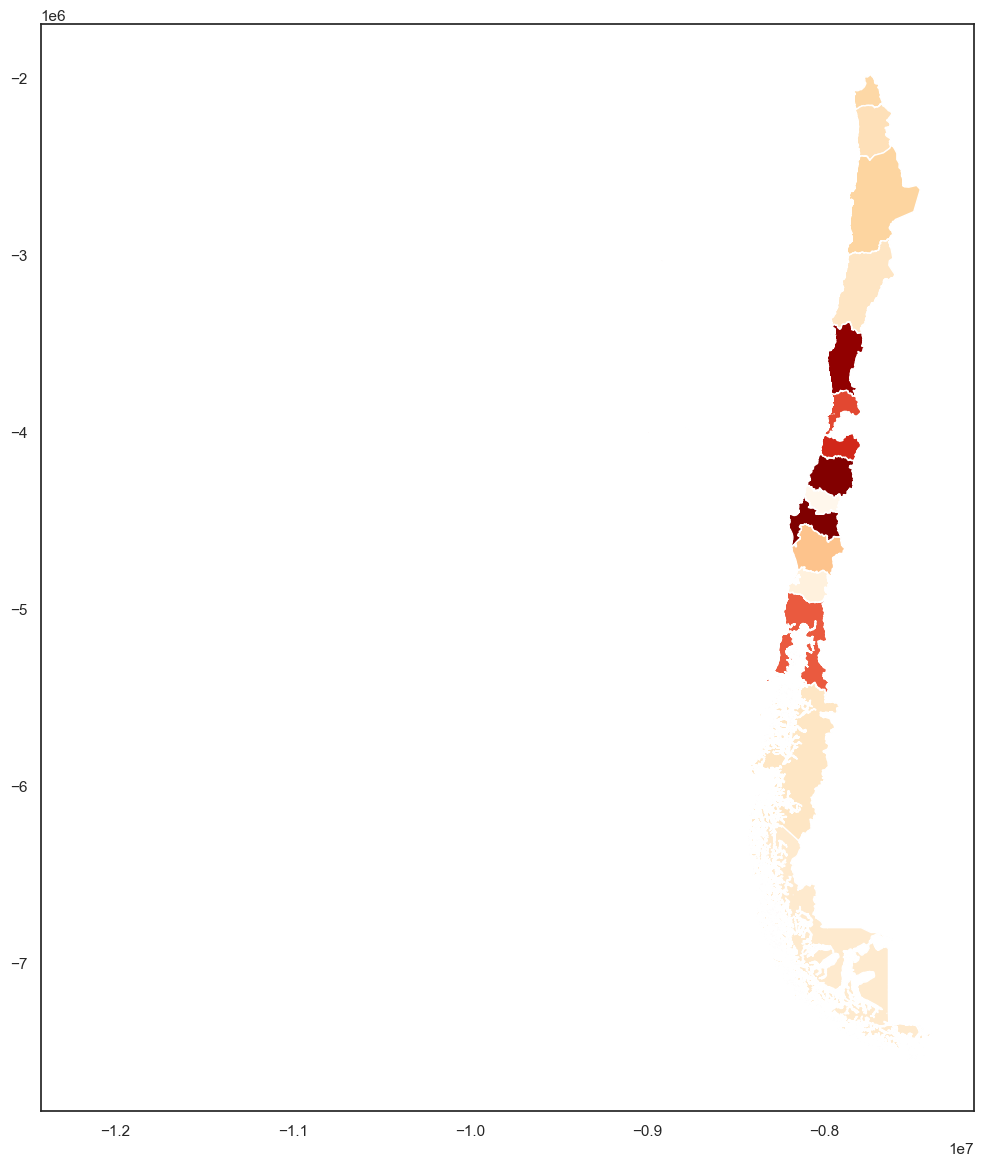

In [93]:
# Set the figure size
fig, ax = plt.subplots(1, 1, figsize=(10, 15))

# Plot the GeoDataFrame
resumen_regiones_filtrado.query("Region != 'Región Metropolitana de Santiago'").plot(
    column="rut", cmap="OrRd", ax=ax
)

plt.tight_layout()

# Show the plot
plt.show()